In [1]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize


Using TensorFlow backend.


In [2]:
import pandas as pd
data = pd.read_csv('driving_log.csv', header = None)
data.columns = ["center_images","left_images","right_images","steering","brake","throttle","speed"]
len(data)

8036

In [3]:
Y_train = np.copy(data['steering'])  


In [4]:
X_train = np.copy(data['center_images']+':'+data['left_images']+':'+data['right_images'])


In [5]:
len(X_train)

8036

In [6]:
img_rows = 66
img_cols = 200
ch = 3

This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)


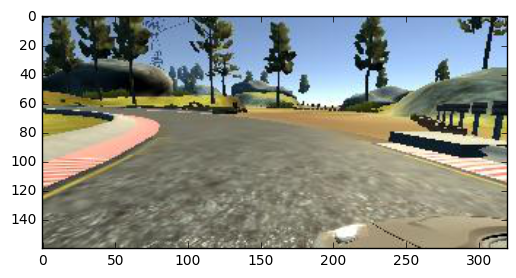

In [7]:
#reading in an image
image = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

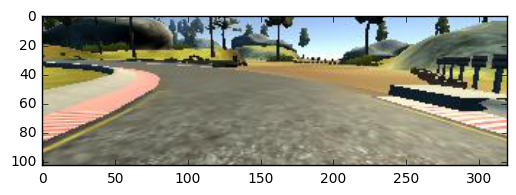

In [8]:
oriimage = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg', 1)
#crop face before resize
crop_face = oriimage[32:135, :]
# do any preprocessing... resize, reshape, etc. here
#newimage = cv2.resize(crop_face, (200, 66))
# crop 20% from bottom to remove car hood and 25 pixels from top
 
plt.imshow(crop_face)

In [9]:
#Resize to image to half or 50% of cropped image
newimage = imresize(crop_face, 0.5, interp='bilinear', mode=None)
newimage.shape

(51, 160, 3)

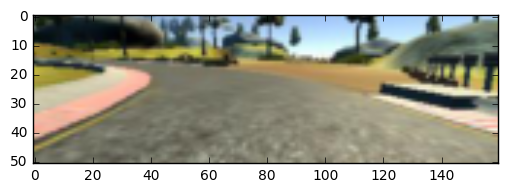

In [10]:
plt.imshow(newimage)

In [11]:
def load_image(imagepath):
    oriimage = mpimg.imread(imagepath, 1)
    #crop face before resize
    #Remove 20% from the bottom to eliminate the car hood
    # 25 pixels from the top to concentrate on the road
    crop_face = oriimage[32:135, :]
    #Resize to image to half or 50% of cropped image
    newimage = imresize(crop_face, 0.5, interp='bilinear', mode=None)
    return newimage

In [12]:
newimage.shape

(51, 160, 3)

In [13]:
def flip_image(image):
    flipimage = np.flipud(image)
    return flipimage

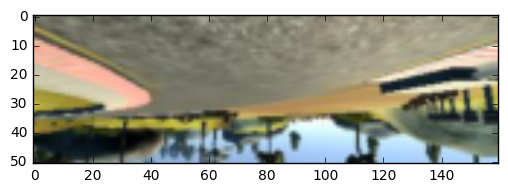

In [14]:
flipimage = np.flipud(newimage)
plt.imshow(flipimage)

In [15]:
batch_size = 64
nb_epoch = 2
number_of_rows = 8036
image_rows = 51
image_columns = 160
image_channels = 3

In [16]:
"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D

In [17]:
#Formula is (image_size - (filter_size+1))/stride, for valid padding.

In [18]:
batch_images = np.zeros((image_rows, image_columns, image_channels))
#batch_steering = np.zeros(number_of_rows)

In [19]:
def batchgen(X, Y):
    steer_offset = 0.25
    counter = 0
    while 1:       
        for i in range(number_of_rows):
            y = Y[counter]
            probability = random.random()
            if probability > 0.75 or y > 0.1 and counter < number_of_rows:
                if y <  -0.01:
                    chance = random.random()
                    if chance > 0.75:
                        imagepath = X[counter].split(':')[1]
                        y = y + steer_offset
                    else:
                        if chance > 0.5:
                            imagepath = X[counter].split(':')[1]
                            y = y + steer_offset    
                        else:
                            if chance > 0.25:
                                imagepath = X[counter].split(':')[0]
                                #y = y + steer_offset
                            else:
                                imagepath = X[counter].split(':')[0]
                                #y = y + steer_offset
                elif y > 0.01:
                    chance = random.random()
                    if chance > 0.75:
                        imagepath = X[counter].split(':')[2]
                        y = y - steer_offset       
                    else:
                        if chance > 0.5:
                            imagepath = X[counter].split(':')[2]
                            y = y - steer_offset
                        else:
                            if chance > 0.25:
                                imagepath = X[counter].split(':')[0]
                                y = y - steer_offset
                            else:
                                imagepath = X[counter].split(':')[0]
                                y = y - steer_offset
                                    
                else:
                    imagepath = X[counter].split(':')[0]
                  
                image = load_image(imagepath)
                y = np.array([[y]])
                if np.random.choice([True, False]):
                    image = flip_image(image)
                    y = -y
                #image = image.reshape(1, image_rows, image_columns, image_channels)
                batch_images[counter] = image
                batch_steering[counter] = y
                print(imagepath, counter)        
                yield batch_images[counter], batch_steering[counter]
            counter = counter + 1

In [20]:
def get_model():
    
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.,
           input_shape = (image_rows, image_columns, image_channels),
           output_shape = (image_rows, image_columns, image_channels)))
    model.add(Convolution2D(24,5, 5, input_shape = (image_rows, image_columns, image_channels), subsample=(2, 2), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(.2))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(.2))
    #model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    #model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Convolution2D(64, 2, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dense(1))    
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss="mse", metrics=['accuracy'])
    return model

In [21]:
model = get_model()

In [22]:
history = model.fit_generator(batchgen(X_train, Y_train), samples_per_epoch = 256, nb_epoch = nb_epoch,
                    verbose=1, max_q_size = 64, callbacks=[], validation_data=None, class_weight=None,
                     pickle_safe=False)

Epoch 1/2


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 409, in data_generator_task
    generator_output = next(generator)
  File "<ipython-input-19-449abae28143>", line 51, in batchgen
    batch_images[counter] = image
ValueError: could not broadcast input array from shape (51,160,3) into shape (160,3)



ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [ ]:
model.summary()

In [ ]:


model.save_weights("model.h5", True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
print("Saved model weights and configuration file.")